# Load Library

In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, udf
from pyspark.sql.types import FloatType, StructType, ArrayType

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Imputer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import seaborn as sns


# Create SparkSession

In [25]:
spark = SparkSession.builder \
    .appName("Motor Vehicle Collisions Analysis") \
    .getOrCreate()

# Load Data

In [26]:
data_path = "Motor_Vehicle_Collisions_-_Crashes.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
df.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: strin

# Data Preprocessing

## Transforming data

In [27]:
# Mengonversi kolom 'CRASH DATE' menjadi tipe Date dengan format yang sesuai
df = df.withColumn("CRASH DATE", to_date(col("CRASH DATE"), "MM/dd/yyyy"))
# Menggabungkan kolom tanggal dan waktu menjadi satu string timestamp
df = df.withColumn("CRASH TIMESTAMP", concat_ws(" ", col("CRASH DATE"), col("CRASH TIME")))
# Mengonversi string timestamp ke tipe timestamp
df = df.withColumn("CRASH TIMESTAMP", to_timestamp(col("CRASH TIMESTAMP"), "yyyy-MM-dd H:mm"))
# Menambahkan kolom tahun dengan menggunakan fungsi year
df = df.withColumn("YEAR", year(col("CRASH TIMESTAMP")))
# Menambahkan kolom tahun dengan menggunakan fungsi month
df = df.withColumn("MONTH", month(col("CRASH TIMESTAMP")))
# Menambahkan kolom tahun dengan menggunakan fungsi day
df = df.withColumn("DAY", day(col("CRASH DATE")))
# Menambahkan kolom tahun dengan menggunakan fungsi Hour
df = df.withColumn("HOUR", hour(col("CRASH TIMESTAMP")))

## Aggregating data

In [28]:
# Summing up the injury and fatality related columns
df = df.withColumn('TOTAL INJURED', 
                              col('NUMBER OF PERSONS INJURED') + 
                              col('NUMBER OF PEDESTRIANS INJURED') + 
                              col('NUMBER OF CYCLIST INJURED') + 
                              col('NUMBER OF MOTORIST INJURED')) \
                  .withColumn('TOTAL KILLED', 
                              col('NUMBER OF PERSONS KILLED') + 
                              col('NUMBER OF PEDESTRIANS KILLED') + 
                              col('NUMBER OF CYCLIST KILLED') + 
                              col('NUMBER OF MOTORIST KILLED'))
df = df.withColumn("TOTAL KILLED", ceil(col("TOTAL KILLED"))).withColumn("TOTAL INJURED", ceil(col("TOTAL INJURED")))

# EDA

## Visulaization

### Hotspot kecelakaan

In [29]:
hotspots = df.groupBy("BOROUGH").count().orderBy(count("BOROUGH").desc())
hotspots.show(5)

+-------------+------+
|      BOROUGH| count|
+-------------+------+
|     BROOKLYN|458045|
|       QUEENS|385946|
|    MANHATTAN|321922|
|        BRONX|212906|
|STATEN ISLAND| 60439|
+-------------+------+
only showing top 5 rows



### WAKTU KECELAKAAN

In [30]:
time_analysis = df.groupBy("HOUR").count().orderBy(count("HOUR").desc())
time_analysis.show(5)

+----+------+
|HOUR| count|
+----+------+
|  16|150211|
|  17|147063|
|  14|139057|
|  15|130539|
|  18|129378|
+----+------+
only showing top 5 rows



In [31]:
time_analysis = df.groupBy("YEAR").count().orderBy(count("YEAR").desc())
time_analysis.show(5)

+----+------+
|YEAR| count|
+----+------+
|2018|231564|
|2017|231007|
|2016|229831|
|2015|217694|
|2019|211486|
+----+------+
only showing top 5 rows



In [32]:
time_analysis = df.groupBy("MONTH").count().orderBy(count("MONTH").desc())
time_analysis.show(5)

+-----+------+
|MONTH| count|
+-----+------+
|   10|188566|
|    7|184891|
|    9|182406|
|    8|182307|
|   12|179405|
+-----+------+
only showing top 5 rows



### PENYEBAB KECELAKAAN

In [33]:
causes = df.groupBy("CONTRIBUTING FACTOR VEHICLE 1").count().orderBy(count('CONTRIBUTING FACTOR VEHICLE 1').desc())
causes.show(5)

+-----------------------------+------+
|CONTRIBUTING FACTOR VEHICLE 1| count|
+-----------------------------+------+
|                  Unspecified|710122|
|         Driver Inattentio...|418621|
|         Failure to Yield ...|124251|
|         Following Too Clo...|111858|
|             Backing Unsafely| 77146|
+-----------------------------+------+
only showing top 5 rows



### JENIS KENDARAAN YANG TERLIBAT

In [34]:
vehicle_types = df.groupBy('VEHICLE TYPE CODE 1').count().orderBy(count('VEHICLE TYPE CODE 1').desc())
vehicle_types.show(5)

+--------------------+------+
| VEHICLE TYPE CODE 1| count|
+--------------------+------+
|               Sedan|582900|
|Station Wagon/Spo...|458363|
|   PASSENGER VEHICLE|416205|
|SPORT UTILITY / S...|180291|
|                Taxi| 51931|
+--------------------+------+
only showing top 5 rows



### HUBUNGAN ANTARA FAKTOR PENYEBAB DAN JENIS KENDARAAN

In [35]:
cause_vehicle_relation = df.groupBy('CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1').count().orderBy(count('CONTRIBUTING FACTOR VEHICLE 1').desc())
cause_vehicle_relation.show(5)

+-----------------------------+--------------------+------+
|CONTRIBUTING FACTOR VEHICLE 1| VEHICLE TYPE CODE 1| count|
+-----------------------------+--------------------+------+
|                  Unspecified|   PASSENGER VEHICLE|226789|
|                  Unspecified|               Sedan|146364|
|         Driver Inattentio...|               Sedan|140992|
|         Driver Inattentio...|Station Wagon/Spo...|115160|
|                  Unspecified|Station Wagon/Spo...|103423|
+-----------------------------+--------------------+------+
only showing top 5 rows



# Modelling

## Feature Selection

In [36]:
selected_columns = ['CRASH DATE','YEAR', 'MONTH', 'DAY','HOUR','COLLISION_ID', 'BOROUGH','NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', "TOTAL KILLED", "TOTAL INJURED"]
df = df.select(selected_columns)
df.printSchema()

root
 |-- CRASH DATE: date (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- TOTAL KILLED: long (nullable = true)
 |-- TOTAL INJURED: long (nullable = true)



In [37]:
# Export to CSV
output = df.toPandas()
output.to_csv('output.csv', index=False)

## KMEANS

### Select Features

In [16]:
selected_columns = ['CRASh DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'COLLISION_ID', 'BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1', 'TOTAL KILLED', 'TOTAL INJURED']
df = df.select(selected_columns)
df.printSchema()

df.groupBy('YEAR', 'MONTH').agg(
    sum('TOTAL INJURED').alias('TOTAL INJURED'),
    sum('TOTAL KILLED').alias('TOTAL KILLED'),
    count('COLLISION_ID').alias('FREQUENCY')
)

root
 |-- CRASh DATE: date (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- TOTAL KILLED: long (nullable = true)
 |-- TOTAL INJURED: long (nullable = true)



DataFrame[YEAR: int, MONTH: int, TOTAL INJURED: bigint, TOTAL KILLED: bigint, FREQUENCY: bigint]

### Impute Missing Value

In [17]:
imputer = Imputer(inputCols=["TOTAL KILLED", "TOTAL INJURED"], 
                  outputCols=["TOTAL KILLED", "TOTAL INJURED"])
df = imputer.fit(df).transform(df)

### Assemle Features

In [18]:
# Assemble features
vecAssembler = VectorAssembler(inputCols=["TOTAL KILLED", "TOTAL INJURED"], outputCol="features")
df_kmeans = vecAssembler.transform(df)

### KMeans Clustering

In [19]:
# KMeans model with 3 clusters
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(df_kmeans)

### Prediction

In [20]:
# Predictions
predictions = model.transform(df_kmeans)

### Output

In [21]:
output = predictions.toPandas()

In [22]:
output.head()

,CRASh DATE,YEAR,MONTH,DAY,HOUR,COLLISION_ID,BOROUGH,CONTRIBUTING FACTOR VEHICLE 1,TOTAL KILLED,TOTAL INJURED,features,prediction
0,2021-09-11,2021.0,9.0,11.0,2.0,4455765.0,None,Aggressive Driving/Road Rage,0,4,"[0.0, 4.0]",1
1,2022-03-26,2022.0,3.0,26.0,11.0,4513547.0,None,Pavement Slippery,0,2,"[0.0, 2.0]",1
2,2022-06-29,2022.0,6.0,29.0,6.0,4541903.0,None,Following Too Closely,0,0,"(0.0, 0.0)",0
3,2021-09-11,2021.0,9.0,11.0,9.0,4456314.0,BROOKLYN,Unspecified,0,0,"(0.0, 0.0)",0
4,2021-12-14,2021.0,12.0,14.0,8.0,4486609.0,BROOKLYN,None,0,0,"(0.0, 0.0)",0


ValueError: Could not interpret value `Total Killed` for `x`. An entry with this name does not appear in `data`.

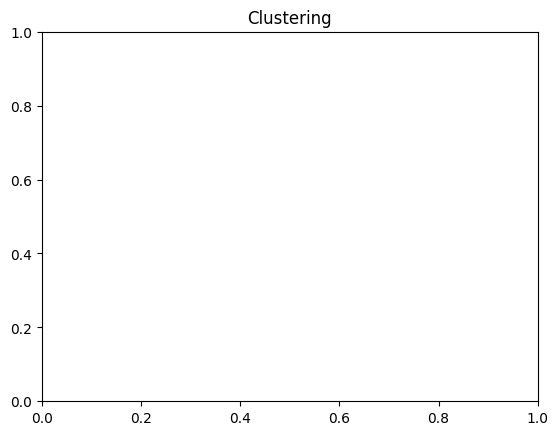

In [23]:
plt.title('Clustering')
sns.scatterplot(x='Total Killed', 
                y='Total Injured', 
                hue='prediction',
                s=100,
                data=output);